In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from sklearn import metrics
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cpu')

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance).

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [17]:
print("Started running car segmentation model.")
BATCH_SIZE = 64

black_5_doors_arrays = {}
orange_3_doors_arrays = {}
photo_arrays = {}
ARRAYS_FOLDER = './arrays/'
npy_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.endswith('.npy')]

# Categorize the arrays based on the file names
for file in npy_files:
    file_path = os.path.join(ARRAYS_FOLDER, file)
    
    # Load the numpy array and normalize by dividing with the maximum value
    sample_tensor = torch.from_numpy(np.load(file_path)) / 255
    
    sample_tensor = sample_tensor.permute(2, 0, 1)  # Reshaping from HxWxC to CxHxW
    
    # Extract the image data and target values
    image_data = sample_tensor[0:3,:,:]  # First 3 channels are the image data
    target = sample_tensor[3,:,:]  # Fourth channel contains target values
    
    if file.startswith('black_5_doors'):
        black_5_doors_arrays[file] = {'image_data': image_data, 'target': target}       
    elif file.startswith('orange_3_doors'):
        orange_3_doors_arrays[file] = {'image_data': image_data, 'target': target}
    elif file.startswith('photo_'):
        photo_arrays[file] = {'image_data': image_data, 'target': target}
        
image_data_list = []
target_list = []

# Loop through the list of dictionaries and extract image_data
for data_dict in black_5_doors_arrays:
    image_data = black_5_doors_arrays[data_dict]['image_data']
    target_data = black_5_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in orange_3_doors_arrays:
    image_data = orange_3_doors_arrays[data_dict]['image_data']
    target_data = orange_3_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in photo_arrays:
    image_data = photo_arrays[data_dict]['image_data']
    target_data = photo_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)


images_tensor = torch.stack(image_data_list, dim=0)
masks_tensor = torch.stack(target_list, dim=0)
dataset = TensorDataset(images_tensor, masks_tensor)

DATASET_LENGTH = len(dataset)
train_size = math.floor(DATASET_LENGTH * 0.8)
val_size = math.floor(DATASET_LENGTH * 0.1)
test_size = DATASET_LENGTH - train_size - val_size

generator_seed = torch.Generator().manual_seed(0)
train_set, temp_set = random_split(dataset, [train_size, val_size + test_size], generator=generator_seed)
val_set, test_set = random_split(temp_set, [val_size, test_size], generator=generator_seed)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # x1 and x2 need to have the same number of rows, I think
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # maybe wrap this in a sigmoid?

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.inc = (ConvBlock(3, 64, 64)) 
        self.down1 = (Down(64, 128)) 
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, 1))

    def forward(self, x):
        x1 = self.inc(x)  # x1 HxW: 256x256
        x2 = self.down1(x1)  # x2 HxW: 128x128
        x3 = self.down2(x2)  # x3 HxW: 64x64
        x4 = self.down3(x3)  # x4 HxW: 32x32
        x5 = self.down4(x4)  # x5 HxW: 16x16
        x = self.up1(x5, x4)  # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


def accuracy(outputs, targets):
    # Assuming binary segmentation
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()  # Convert to binary predictions
    correct = (preds == targets).sum().item()
    total = targets.numel()
    acc = correct / total
    return acc


def save_model(model, optimizer, save_path):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')


def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model loaded from {load_path}')
    return model, optimizer


def evaluate_validation_set(model, device, loss_fn):
    val_steps = math.ceil(len(val_set) / BATCH_SIZE)

    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_acc = 0
        for inputs, masks in val_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            output = model(inputs)
            val_loss += loss_fn(output.squeeze(), masks).item()

            batch_acc = accuracy(output.squeeze(), masks.to(device))
            val_acc += batch_acc

        val_acc /= len(val_loader)
        val_loss /= val_steps
        return val_loss, val_acc


def train_model(model, epochs, optimizer, loss_fn, save_path):
    if not torch.cuda.is_available():
        print("CUDA NOT AVAILABLE!!!!")
    else:
        print("CUDA WORKING!!!")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_steps = math.ceil(len(train_set) / BATCH_SIZE)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_acc = 0
        model.train()
        
        for step, (inputs, masks) in enumerate(train_loader, 1):  # Start counting steps from 1
            # print(f"Epoch: {epoch}, step: {step} out of {train_steps}.")
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            batch_loss = loss_fn(output.squeeze(), masks)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
            
            batch_acc = accuracy(output, masks)
            epoch_acc += batch_acc
        
        epoch_acc /= train_steps
        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss / train_steps)

        val_loss, val_acc = evaluate_validation_set(model, device, loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch train loss: {train_losses[-1]}, train accuracy: {train_accuracies[-1]}")
        print(f"Epoch validation loss: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}")

    if save_path is not None:
        save_model(model, optimizer, save_path)

Started running car segmentation model.


In [ ]:
# Load the trained model
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, load_path)

# Choose an example from the test set
example_index = 12
example_input, example_target = test_set[example_index]
example_input = example_input.unsqueeze(0)  # Add a batch dimension

# Move the input to the appropriate device (CPU or GPU)
example_input = example_input.to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Make a prediction
with torch.no_grad():
    prediction = loaded_model(example_input)

# Post-process the prediction if needed (e.g., convert to probabilities)
predicted_mask = (prediction*255).squeeze()

# Visualize the input, target, and predicted mask
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(example_input.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(example_target.cpu().numpy())
plt.title('Target Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.cpu().numpy())
plt.title('Predicted Mask')

plt.show()


In [ ]:
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, load_path)
loss_fn = nn.BCEWithLogitsLoss()

# Very very slow on CPU, to be added to the end of the train method, after all epochs are done
# with torch.no_grad():
#     loaded_model.eval()
#     test_loss = 0
#     test_acc = 0
#     for inputs, masks in test_loader:
#         inputs, masks = inputs.to(device), masks.to(device)
#         output = loaded_model(inputs)
#         output = output.squeeze()
        
#         test_loss += loss_fn(output, masks).item()
#         batch_acc = accuracy(output, masks.to(device))
#         test_acc += batch_acc

#     test_acc /= len(test_loader)
#     test_loss /= val_steps
#     print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

loaded_model.eval()
with torch.no_grad():
    for input_image, target in test_set:
        input_image = input_image.to(device).unsqueeze(0)
        prediction = loaded_model(input_image)
        prediction = prediction.squeeze() * 255
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(target.cpu().numpy())
        plt.title('Target Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(prediction.cpu().numpy())
        plt.title('Predicted Mask')

        plt.show()

tensor([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=torch.uint8)


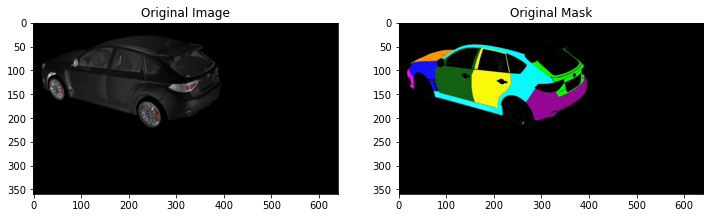

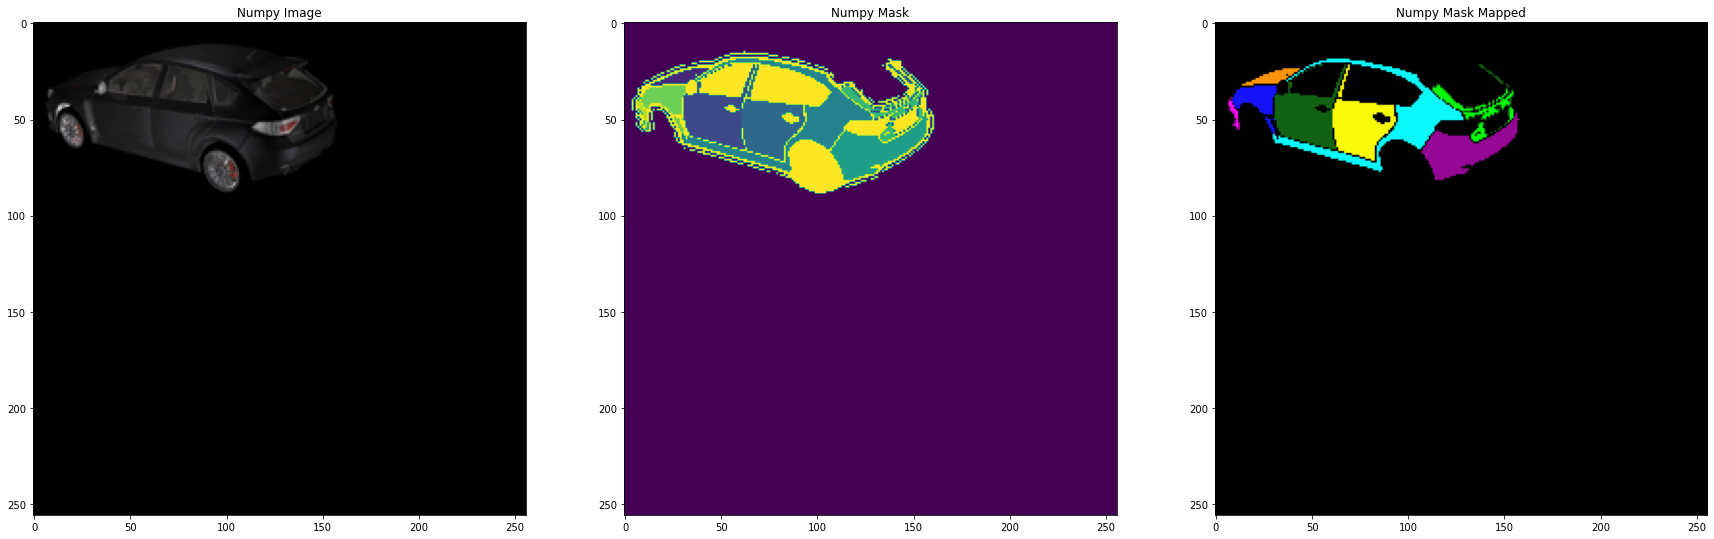

In [49]:
IMAGES_FOLDER = './carseg_data/images/'
ARRAYS_FOLDER = './arrays/'
BLACK_CAR_FOLDER = 'black_5_doors'
ORANGE_CAR_FOLDER = 'orange_3_doors'
REAL_CAR_FOLDER = 'photo'
SEGMENTATION_FOLDER = '/with_segmentation/'
NO_SEGMENTATION_FOLDER = '/no_segmentation/'

CAR_FOLDER = BLACK_CAR_FOLDER
IMAGE_INDEX = '0250' # good indexes orange: 0050, 0250, 1050

image_original = torchvision.io.read_image(IMAGES_FOLDER + CAR_FOLDER + NO_SEGMENTATION_FOLDER + IMAGE_INDEX + ".png")
image_segmented = torchvision.io.read_image(IMAGES_FOLDER + CAR_FOLDER + SEGMENTATION_FOLDER + IMAGE_INDEX + ".png")

npy_image = np.load(ARRAYS_FOLDER + CAR_FOLDER + "_" + IMAGE_INDEX + '.npy')
print(torch.from_numpy(npy_image[:,:,3]).unique())
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_original.permute(1, 2, 0))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image_segmented.permute(1, 2, 0))
plt.title('Original Mask')

plt.show()

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(npy_image[:,:,0:3])
plt.title('Numpy Image')

plt.subplot(1, 3, 2)
plt.imshow(npy_image[:,:,3])
plt.title('Numpy Mask')

plt.subplot(1, 3, 3)
plt.imshow(map_numpy_mask(npy_image[:,:,3]))
plt.title('Numpy Mask Mapped')

plt.show()

### Segmentation class mappings (open cell to see better)

"color",        "description",          "class value",  "color values"
"orange",       "hood",                 10              (250, 149, 10)
"dark green",   "front door",           20              (19, 98, 19)
"yellow",       "rear door",            30              (249, 249, 10)
"cyan",         "frame",                40              (10, 248, 250)
"purple",       "rear quater panel",    50              (149, 7, 149)
"light green",  "trunk lid",            60              (5, 249, 9)
"blue",         "fender",               70              (20, 19, 249)
"pink",         "bumper",               80              (249, 9, 250)
"no color",     "rest of car",          90              NA

In [44]:
def map_numpy_mask(original_mask):
    new_mask = torch.zeros(256, 256, 3)
    for i in range (len(original_mask)):
        for j in range (len(original_mask[0])):
            current_pixel = original_mask[i][j]
            if current_pixel == 10:
                new_mask[i][j] = torch.tensor([250, 149, 10])
            elif current_pixel == 20:
                new_mask[i][j] = torch.tensor([19, 98, 19])
            elif current_pixel == 30:
                new_mask[i][j] = torch.tensor([249, 249, 10])
            elif current_pixel == 40:
                new_mask[i][j] = torch.tensor([10, 248, 250])
            elif current_pixel == 50:
                new_mask[i][j] = torch.tensor([149, 7, 149])
            elif current_pixel == 60:
                new_mask[i][j] = torch.tensor([5, 249, 9])
            elif current_pixel == 70:
                new_mask[i][j] = torch.tensor([20, 19, 249])
            elif current_pixel == 80:
                new_mask[i][j] = torch.tensor([249, 9, 250])
            elif current_pixel == 90:
                new_mask[i][j] = torch.tensor([0, 0, 0])
    
    return new_mask / 255

In [19]:
# model.save('trained_model.h5')

In [20]:
# Run the output on the test set

In [21]:
# Try pretrained models: MobileNetV2, ResNet101